# Solución del Modelo Neoclásico de Crecimiento usando Programación Dinámica e Iteración de la Función Valor

Profesor: Rafael R. Guthmannn
Ayudante:  David Limpe Cruz

MAE 2023 - Universidad Alberto Hurtado

---

### El Problema de Opmización 

El problema de optimización del planificador central es el siguiente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+i_{t}=Ak_{t}^{\alpha}\\
 &  & k_{t+1}=i_{t}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

Alternativamente:
\begin{eqnarray*}
\max U_{0} & = & \sum_{t=0}^{\infty}\beta^{t}\ln c_{t}\\
s.a &  & c_{t}+k_{t+1}=Ak_{t}^{\alpha}\\
 &  & k_{0}\,dado.
\end{eqnarray*}

La ecuación de Bellman es:
$$
v(k_{t})=\max_{k_{t+1}}\left\{ \log\left(Ak_{t}^{\alpha}-k_{t+1}\right)+\beta v(k_{t+1})\right\} 
$$

### Solución Algebraica

La solución del problema funcional está dada por la función valor y la función de política:

$$
v(k_{k})\,\,y\,\,k_{t+1}=g(k_{t})
$$

Conocemos la solución de este problema:

\begin{eqnarray*}
k_{t+1} & = & \frac{\beta F}{1+\beta F}Ak_{t}^{\alpha}\\
v(k_{t}) & = & E+F\ln(k_{t})
\end{eqnarray*}
Donde:
\begin{eqnarray*}
E & = & \frac{1}{1-\beta}\left[\ln\left(A\left(1-\alpha\beta\right)\right)+\frac{\alpha\beta}{1-\alpha\beta}\ln\left(Aa\beta\right)\right]\\
F & = & \frac{\alpha}{1-\alpha\beta}
\end{eqnarray*}

La idea es implementar la solución numérica en Julia y compararla con la obtenida algebraicamente.

### Implementación

Algoritmo:

1. Definir un grid de puntos $k$ (discretización) y realizar una conjetura para $v(k)$ en cada posible punto del grid. 
2. Usando la conjetura evaluar el operador $Tv$ para cada punto en el grid (esto implica resolver el $\max$).
3. Evaluar si $v=Tv$ (usando algún grado de tolerancia), en tal caso terminar el proceso. Caso contrario volver al punto 2 usando la función valor resultante.

En términos de la ecuación de Bellman, la iteración sería:
$$
v_{j+1}(k)=\max_{k'}\left\{ \ln\left(Ak^{\alpha}-k'\right)+\beta v_{j}(k')\right\} 
$$

Partir con algún $v_{0}(k)$. 

In [2]:
# Discretizamos la variable de estado. Definimos primero el número de puntos en el grid de k
n = 500

500

Parametros del modelo:

In [3]:
A = 1      # tecnologia
α = 0.36   #  participacion del capital   
β = 0.9;   #  factor de descuento  

Definimos el grado de tolerancia de la iteración de la función valor:

In [4]:
crit = 1e-6   # valor critico de convergencia

1.0e-6

Definimos el grid de puntos de $k$ como $k_1,...,k_n \in [0.6k^*,1.4k^*]$

In [5]:
# Calcular kss y definir kgrid  
kss   = (α*β)^(1/(1-α))                       # capital en EE    
kgrid = kss * collect(range(0.6,stop=1.4,length=n));  # n x 1  
#println(kgrid)

In [9]:
# kss = 0.17188..
kgrid

500-element Vector{Float64}:
 0.10312829289334823
 0.10340385279419885
 0.1036794126950495
 0.10395497259590013
 0.10423053249675075
 0.10450609239760138
 0.104781652298452
 0.10505721219930263
 0.10533277210015328
 0.1056083320010039
 0.10588389190185453
 0.10615945180270515
 0.10643501170355578
 ⋮
 0.23760152450845562
 0.23787708440930622
 0.23815264431015687
 0.2384282042110075
 0.23870376411185812
 0.23897932401270877
 0.23925488391355937
 0.23953044381441002
 0.23980600371526065
 0.24008156361611127
 0.2403571235169619
 0.24063268341781252

Note que mientras más puntos tengamos en el grid, más precisión tendremos.

El siguiente paso es iterar la función valor partiendo de la siguiente conjetura:
$$
v_{0}(k)=\left[\begin{array}{c}
0\\
\vdots \\
0
\end{array}\right]
$$

In [11]:
# Definir valores inciales
val0 = zeros(n)  # Conjetura Inicial  
valiter = val0;  # Vector donde guardamos las iteraciones

In [12]:
using Optim
using Interpolations

Usamos interpolación lineal para evaluar la función entre los puntos definidos en el grid del capital.

In [13]:
v_interpolate = LinearInterpolation(kgrid, val0, extrapolation_bc = Line())
v_interpolate(kss)

0.0

Resolvemos usando el método de iteración de la función valor:

In [14]:
diff = 1

val1  = zeros(n)  # Vector para guardar la función valor
kdeci = zeros(n)  # Vector para guardar la función de política 

while diff > crit
    
    global val0, val1, valiter, kdeci, diff
    
    v_interpolate = LinearInterpolation(kgrid, val0, extrapolation_bc = Line())                      
    Tv(k,kf) = log(A*k^α-kf) + β*v_interpolate(kf) 
    
    for i in 1:n
        res = optimize(x -> -Tv(kgrid[i],x), 1e-10, A*kgrid[i]^α)
        kdeci[i] = res.minimizer
        val1[i] = -res.minimum
    end
    
    diff = abs(maximum(val1-val0))      
    println(diff)
    valiter = [valiter val1]
    val0 = copy(val1) 
end

println("Convergencia = $diff");

0.512814111777629
0.9028941988379156
0.8533092180821951
0.7769852537578146
0.7018303348525388
0.6324338075998632
0.5694415400214998
0.5125781401429776
0.46134660551006856
0.4152203281441018
0.3737009830445386
0.33633192822418767
0.3026988505106356
0.27242918972080776
0.24518628707698564
0.22066766489736622
0.1986009016662944
0.17874081332486114
0.16086673309220068
0.14478006047354697
0.13030205486992763
0.11727184967710969
0.10554466490150283
0.09499019853734758
0.08549117876306411
0.07694206093405676
0.069247854863411
0.06232306938355947
0.05609076244520139
0.0504816862015236
0.04543351758066727
0.040890165822567326
0.03680114924030953
0.033121034316261344
0.029808930884403395
0.026828037795480597
0.024145234016000217
0.021730710614454196
0.019557639553005046
0.01760187559758819
0.015841688037827595
0.014257519234039506
0.012831767310586883
0.011548590578785323
0.010393731520723648
0.009354358367708926
0.008418922532030138
0.007577030278806518
0.006819327250930485
0.006137394524735384

### Solución Algebraica

Para este problema particular conocemos la solución alebraica.

In [16]:
# Computar los coeficiente E y F 
E1 = log(A*(1 - α*β))
E2 = α*β/(1 - α*β) * log(A*α*β)
E = 1/(1 - β)*(E1 + E2)
F = α/(1 - α*β)

# Evaluar en la solucion algebraica la FV y la FP en kgrid
val_cs = E*ones(n) + F * log.(kgrid)            # n x 1
kdeci_cs = β*F/(1 + β*F)*A*kgrid.^α;            # n x 1

### Gráficos

In [17]:
using Plots
gr()

Plots.GRBackend()

Función de política:

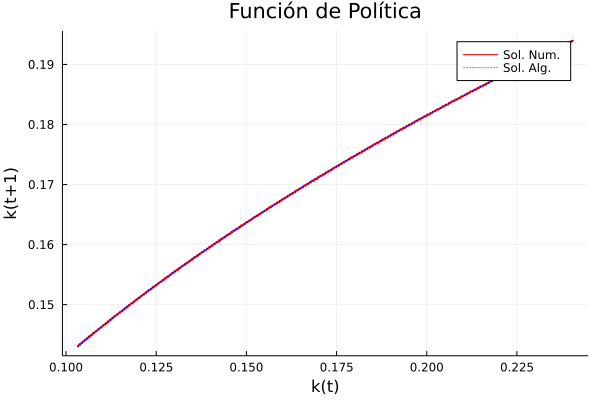

In [15]:
plot(kgrid, [kdeci kdeci_cs], title = "Función de Política", 
     xlabel = "k(t)", ylabel = "k(t+1)", label=["Sol. Num." "Sol. Alg."], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])

Función valor:

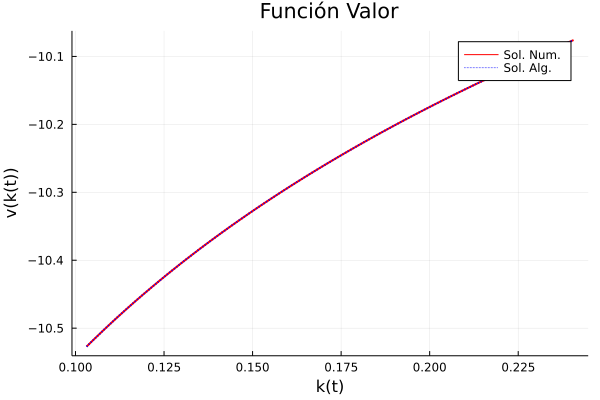

In [16]:
plot(kgrid, [val1 val_cs], title = "Función Valor", 
     xlabel = "k(t)", ylabel = "v(k(t))", label=["Sol. Num." "Sol. Alg."], 
     linewidth = 2, grid = true, line=[:solid :dot], color=[:red :blue])

Proceso de iteración de la función valor:

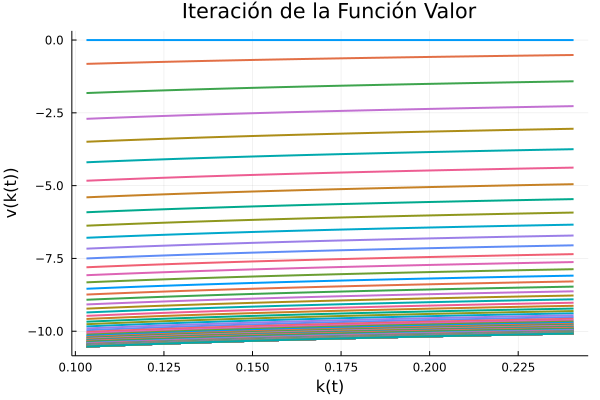

In [17]:
plot(kgrid, valiter, title = "Iteración de la Función Valor", 
     xlabel = "k(t)", ylabel = "v(k(t))", legend = false, linewidth = 2, 
     grid = true)